In [ ]:
%reset

In [1]:
import pandas as pd
import numpy as np

import sys, os

import seaborn as sns
import matplotlib.pyplot as plt

from causalinference import CausalModel

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from importlib import reload

from scipy.stats import wasserstein_distance
from scipy import stats

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
seed=1234
np.random.seed(seed)

In [4]:
def process_data(df, outcome, thresh=0.6):

    # prepare outcomes
    outcomes_to_delete = df.filter(regex='outcome').\
                            columns.\
                            to_list()
    outcomes_to_delete.remove(outcome)
    df.drop(columns=outcomes_to_delete,
            inplace=True)
    df.dropna(subset=[outcome], inplace=True)

    # drop columns with missing values exceeding the thresh
    thresh = round(thresh * len(df.index))
    df = df.dropna(thresh=thresh, axis=1)

    # get dummies
    df = pd.get_dummies(df)
    columns_to_drop = ['gender_M'] + df.filter(regex='False').columns.to_list()
    df.drop(columns=columns_to_drop, inplace=True)

    # convert to bool
    for column in df.select_dtypes(include=['uint8']).columns.to_list():
        df[column] = df[column] == 1

    return df

def get_training_data(df, treatment_col, outcome_col):

    cols_num = df.select_dtypes(include=['float64']).columns.to_list()
    if outcome_col in cols_num:
        cols_num.remove(outcome_col)
    cols_bool = df.select_dtypes(include=['uint8', 'bool']).columns.to_list()
    if treatment_col in cols_bool:
        cols_bool.remove(treatment_col)

    t = df_encoded.loc[:, treatment_col].values
    X_bool = df_encoded[cols_bool].values
    X_num = df_encoded[cols_num].values
    y = df_encoded.loc[:, outcome_col].values


    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(X_num)
    X_num = imp.transform(X_num)
    scaler = StandardScaler().fit(X_num)
    X_num = scaler.transform(X_num)
    X = np.hstack((X_num, X_bool))

    return y, t, X

def get_covariate_names(df, treatment_col, outcome_col):

    cols_num = df.select_dtypes(include=['float64']).columns.to_list()
    if outcome_col in cols_num:
        cols_num.remove(outcome_col)
    cols_bool = df.select_dtypes(include=['uint8', 'bool']).columns.to_list()
    if treatment_col in cols_bool:
        cols_bool.remove(treatment_col)

    return cols_num + cols_bool

In [5]:
os.chdir('/home/adam/adam/causal_inference')
from causal_inference.model.propensity_model import PropensityModel
reload(sys.modules['causal_inference.model.propensity_model'])
from causal_inference.model.propensity_model import PropensityModel

In [6]:
os.chdir('/home/adam/adam/data/19012021/')
df = pd.read_csv('data_guerin_rct.csv')
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6371 entries, 0 to 6370
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   treated                          6371 non-null   bool   
 1   age                              6371 non-null   float64
 2   gender                           6371 non-null   object 
 3   bmi                              6371 non-null   float64
 4   nice_diabetes                    4915 non-null   object 
 5   nice_aki                         3818 non-null   object 
 6   nice_cirrhosis                   4915 non-null   object 
 7   nice_hem_malign                  4915 non-null   object 
 8   nice_copd                        4915 non-null   object 
 9   nice_imm_insuf                   4915 non-null   object 
 10  nice_cardio_vasc_insuf           4915 non-null   object 
 11  nice_morbid_obesity              6371 non-null   bool   
 12  renal_replacement_th

In [7]:
df.loc[df.treated, ['fio2', 'peep', 'po2', 'pf_ratio', 'tidal_volume_per_kg']].describe()

,fio2,peep,po2,pf_ratio,tidal_volume_per_kg
count,1260.000000,1260.000000,1260.000000,1260.000000,1174.000000
mean,78.970556,13.133540,69.445357,90.980159,6.693356
std,14.820638,3.631854,12.831878,22.862411,1.794731
min,60.000000,5.000000,27.750000,34.000000,0.126635
25%,65.000000,10.000000,61.510000,73.000000,5.807030
50%,79.550000,12.945000,67.510000,88.000000,6.536879
75%,95.000000,16.000000,76.000000,107.000000,7.399000
max,100.000000,30.000000,147.760000,149.000000,20.859377


<AxesSubplot:ylabel='Frequency'>

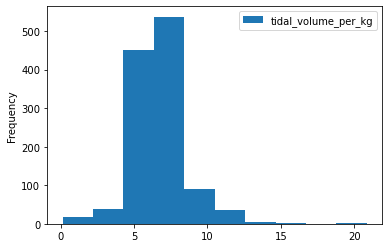

In [8]:
df.loc[df.treated, ['tidal_volume_per_kg']].plot.hist()

In [9]:
df.loc[~df.treated, ['fio2', 'peep', 'po2', 'pf_ratio', 'tidal_volume_per_kg']].describe()

,fio2,peep,po2,pf_ratio,tidal_volume_per_kg
count,5111.000000,5111.000000,5111.000000,5111.000000,4711.000000
mean,71.047349,12.413395,71.456862,103.252984,6.940931
std,12.504143,3.670345,11.656788,21.967766,1.901132
min,60.000000,5.000000,18.000000,23.000000,0.040884
25%,60.000000,10.000000,63.760000,88.000000,5.972259
50%,67.000000,12.000000,70.510000,105.000000,6.746180
75%,80.000000,15.000000,78.000000,119.000000,7.803519
max,100.000000,33.980000,141.010000,149.000000,22.845908


<AxesSubplot:ylabel='Frequency'>

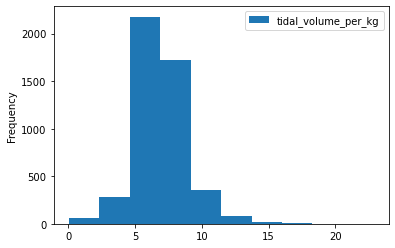

In [10]:
df.loc[~df.treated, ['tidal_volume_per_kg']].plot.hist()

In [11]:
df.loc[df.nice_morbid_obesity & df.treated, ['fio2', 'peep', 'po2', 'pf_ratio', 'tidal_volume_per_kg']].describe()

,fio2,peep,po2,pf_ratio,tidal_volume_per_kg
count,119.000000,119.000000,119.000000,119.000000,115.000000
mean,80.237815,14.263782,68.744622,89.025210,6.718094
std,15.576465,3.343531,11.758084,22.464459,1.760138
min,60.000000,5.000000,34.500000,34.000000,0.217221
25%,65.500000,12.000000,61.255000,71.500000,5.907489
50%,77.000000,14.000000,67.000000,87.000000,6.727570
75%,100.000000,16.050000,74.260000,100.000000,7.622156
max,100.000000,24.470000,126.000000,146.000000,13.940893


In [12]:
df.loc[~df.nice_morbid_obesity & df.treated, ['fio2', 'peep', 'po2', 'pf_ratio', 'tidal_volume_per_kg']].describe()

,fio2,peep,po2,pf_ratio,tidal_volume_per_kg
count,1141.000000,1141.000000,1141.00000,1141.000000,1059.000000
mean,78.838387,13.015662,69.51844,91.184049,6.690670
std,14.740446,3.641820,12.94133,22.903599,1.799245
min,60.000000,5.000000,27.75000,40.000000,0.126635
25%,65.000000,10.000000,61.51000,73.000000,5.790879
50%,79.600000,12.240000,67.51000,89.000000,6.522354
75%,92.000000,15.900000,76.00000,107.000000,7.372692
max,100.000000,30.000000,147.76000,149.000000,20.859377


In [13]:
OUTCOME = 'pf_ratio_2h_8h_manual_outcome'

In [14]:
df.loc[df.treated, OUTCOME].describe()

count    1054.000000
mean      138.376660
std        60.361915
min        36.000000
25%        96.250000
50%       128.000000
75%       162.000000
max       595.000000
Name: pf_ratio_2h_8h_manual_outcome, dtype: float64

In [15]:
df.loc[~df.treated, OUTCOME].describe()


count    4203.000000
mean      123.941946
std        48.660623
min        30.000000
25%        94.000000
50%       115.000000
75%       141.000000
max       669.000000
Name: pf_ratio_2h_8h_manual_outcome, dtype: float64

In [16]:
df_encoded = process_data(df=df, outcome=OUTCOME)
df_encoded.info()

y, t, X = get_training_data(df=df_encoded,
                            treatment_col='treated',
                            outcome_col=OUTCOME)

covariates = get_covariate_names(df=df_encoded,
                                 treatment_col='treated',
                                 outcome_col=OUTCOME)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5257 entries, 1 to 6370
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   treated                        5257 non-null   bool   
 1   age                            5257 non-null   float64
 2   bmi                            5257 non-null   float64
 3   nice_morbid_obesity            5257 non-null   bool   
 4   renal_replacement_therapy      5257 non-null   bool   
 5   sofa_score                     3925 non-null   float64
 6   lactate                        4642 non-null   float64
 7   tidal_volume                   5013 non-null   float64
 8   tidal_volume_per_kg            4923 non-null   float64
 9   respiratory_rate_measured      4564 non-null   float64
 10  peep                           5257 non-null   float64
 11  fio2                           5257 non-null   float64
 12  po2                            5257 non-null   f

## 3. Causal modelling

#### V1: All variables

In [ ]:
propensity_model_all = PropensityModel(outcome=y,
                                   treatment=t,
                                   covariates=X,
                                   outcome_name=OUTCOME,
                                   treatment_name='proned',
                                   covariates_name=covariates)
propensity_model_all.summary_stats()


In [ ]:
propensity_model_all.est_propensity(X=X, t=t, method='balanced')
propensity_model_all.show_propensity()

In [ ]:
np.mean(abs(propensity_model_all.causal_model.summary_stats['ndiff']))

In [ ]:
#propensity_model_all.trim()

In [ ]:
np.mean(abs(propensity_model_all.causal_model.summary_stats['ndiff']))

In [ ]:
propensity_model_all.causal_model.blocks = [0, 0.4, 0.6, 0.75, 1]
propensity_model_all.access_balance(method='default')


In [ ]:
propensity_model_all.est_treatment_effect()

In [ ]:
propensity_model_all.print_models(raw_effect=14.6, true_effect=15)


In [ ]:
propensity_model_all.plot_propensity()

In [ ]:
propensity_model_all.causal_model.estimates['matching']['ate'].round(2)

In [ ]:
propensity_model_all.causal_model.reset()

#### With medically relevant features

V2. Balance only potential confounders

In [ ]:
propensity_model_subset = PropensityModel(outcome=y,
                                          treatment=t,
                                          covariates=X,
                                          outcome_name=OUTCOME,
                                          treatment_name='proned',
                                          covariates_name=covariates)
propensity_model_subset.summary_stats()


In [ ]:
propensity_cols = ['pf_ratio',
                   'peep',
                   'fio2',
                   'tidal_volume_per_kg',
                   'nice_copd_True',
                   'nice_hem_malign_True']

In [ ]:
y_subset, t_subset, X_subset = get_training_data(df=df_encoded[propensity_cols],
                                                 treatment_col='treated',
                                                 outcome_col=OUTCOME)

covariates = get_covariate_names(df=df_encoded[propensity_cols],
                                 treatment_col='treated',
                                 outcome_col=OUTCOME)


print(covariates)

In [ ]:
propensity_model_subset.est_propensity(X=X_subset, t=t, method='balanced')
#propensity_model.est_propensity(X=X_subset, t=t_subset, method='balanced')
propensity_model_subset.show_propensity()

In [ ]:
np.mean(abs(propensity_model_subset.causal_model.summary_stats['ndiff']))

In [ ]:
# propensity_model_subset.trim()

In [ ]:
np.mean(abs(propensity_model_subset.causal_model.summary_stats['ndiff']))

In [ ]:
propensity_model_subset.causal_model.blocks = [0, 0.4, 0.5, 0.6, 0.7, 1]
propensity_model_subset.access_balance(method='default')

In [ ]:
propensity_model_subset.est_treatment_effect()

In [ ]:
propensity_model_subset.print_models(raw_effect=10.5, true_effect=15)

In [ ]:
propensity_model_subset.plot_propensity()

V3. All + interactions + poly

In [ ]:
propensity_model_poly = PropensityModel(outcome=y,
                                        treatment=t,
                                        covariates=X,
                                          outcome_name=OUTCOME,
                                          treatment_name='proned',
                                          covariates_name=covariates)
propensity_model_poly.summary_stats()


In [ ]:
y, t, X = get_training_data(df=df_encoded,
                            treatment_col='treated',
                            outcome_col=OUTCOME)

covariates = get_covariate_names(df=df_encoded,
                                 treatment_col='treated',
                                 outcome_col=OUTCOME)


print(covariates)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
poly.fit_transform(X)
poly = PolynomialFeatures(include_bias=False, interaction_only=True)
X_poly = poly.fit_transform(X)

In [ ]:
propensity_model_poly.est_propensity(X=X_poly, t=t, method='balanced')
#propensity_model.est_propensity(X=X_subset, t=t_subset, method='balanced')
propensity_model_poly.show_propensity()

In [ ]:
np.mean(abs(propensity_model_poly.causal_model.summary_stats['ndiff']))

In [ ]:
#propensity_model_poly.trim()

In [ ]:
np.mean(abs(propensity_model_poly.causal_model.summary_stats['ndiff']))

In [ ]:
propensity_model_poly.causal_model.blocks = [0, 0.4, 0.6, 0.7, 0.8, 1]
propensity_model_poly.access_balance(method='default')

In [ ]:
propensity_model_poly.est_treatment_effect()

In [ ]:
propensity_model_poly.print_models(raw_effect=10.5, true_effect=15)

In [ ]:
propensity_model_poly.plot_propensity()

#### V4: obese patients

In [ ]:
# Choose patients with BMI > 35

morbid_obesity = X[:, 14] > 0

In [ ]:
# The standard raw_effect

print(np.mean(y[t]) - np.mean(y[~t]))

# Raw effect for obese

print(np.mean(y[morbid_obesity & t]) - np.mean(y[morbid_obesity & ~t]))

# and non obese

print(np.mean(y[~morbid_obesity & t]) - np.mean(y[~morbid_obesity & ~t]))

# % of obese

print(len(y[morbid_obesity]) / len(y))

In [ ]:
X.shape

In [ ]:
propensity_model_all = PropensityModel(outcome=y[morbid_obesity],
                                   treatment=t[morbid_obesity],
                                   covariates=np.delete(X[morbid_obesity], 14, 1),
                                   outcome_name=OUTCOME,
                                   treatment_name='proned',
                                   covariates_name=covariates)
propensity_model_all.summary_stats()


In [ ]:
propensity_model_all.est_propensity(X=np.delete(X[morbid_obesity], 14, 1),
                                    t=t[morbid_obesity],
                                    method='balanced')
propensity_model_all.show_propensity()

In [ ]:
np.mean(abs(propensity_model_all.causal_model.summary_stats['ndiff']))

In [ ]:
propensity_model_all.trim()

In [ ]:
np.mean(abs(propensity_model_all.causal_model.summary_stats['ndiff']))

In [ ]:
propensity_model_all.causal_model.blocks = [0, 0.7, 1]
propensity_model_all.access_balance(method='default')


In [ ]:
propensity_model_all.est_treatment_effect()

In [ ]:
propensity_model_all.print_models(raw_effect=14.4, true_effect=15)


## check interactions

## Other computations

In [ ]:
n_of_control = []
n_of_treated = []
p_bin = []
effect = []

for stratum in propensity_model_all.causal_model.strata:
    p_min = stratum.summary_stats['p_min'].round(2)
    p_max = stratum.summary_stats['p_max'].round(2)
    index = '[{},{}]'.format(p_min, p_max)
    p_bin.append(index)

    stratum.est_via_matching(bias_adj=True)
    ate = stratum.estimates['matching']['ate']
    effect.append(ate)

    n_of_control.append(stratum.summary_stats['N_c'])
    n_of_treated.append(stratum.summary_stats['N_t'])

df = pd.DataFrame({'n_of_treated': n_of_treated,
                   'n_of_control': n_of_control,
                   'ate': effect}, index=p_bin)

In [ ]:
ax =  df.plot.bar(y=['n_of_control', 'n_of_treated'], ylabel='Frequency', figsize=(10, 5))
df.plot(y='ate', c='k', ax=ax, use_index=False, secondary_y=True, mark_right=False)
ax.right_ax.set_ylabel('ATE')

In [ ]:
# https://seaborn.pydata.org/examples/pairgrid_dotplot.html


In [ ]:
df_balance = pd.DataFrame([], columns=['raw_diff', 'all', 'all_poly', 'subset', 'subset_poly'])
df_balance.loc[:,'raw_diff'] = propensity_model_all.causal_model.summary_stats['ndiff']
df_balance = df_balance.abs().round(2)

In [ ]:
COLUMN_NAME = 'all'
df_balance[COLUMN_NAME] = 0

In [ ]:
df_strat_balance = pd.DataFrame([])
weights = []
n_of_strata = 0

for stratum in propensity_model_all.causal_model.strata:
    n_of_strata += 1
    column = 'strata_{}'.format(n_of_strata)
    df_strat_balance[column] = stratum.summary_stats['ndiff']
    weights.append(stratum.summary_stats['N'])
df_strat_balance = df_strat_balance.abs()


for row, column in df.iterrows():
    print(row)
    df_balance.loc[row, COLUMN_NAME] = np.average(column, weights=np.asarray(weights)).round(2)

In [ ]:
df_balance.loc['mean'] = df.mean()
df_balance.index = propensity_model.covariates_name

In [ ]:
df_balance


In [ ]:
# What if I train using an XGBoost?


def compare_balance()

#### OLS estimation

In [17]:
import statsmodels.api as sm
import numpy as np

In [ ]:
morbid_obesity = X[:, 14] > 0

In [ ]:
X_new = sm.add_constant(np.hstack((t.reshape((len(t), 1)),X)))

In [ ]:
len(t[morbid_obesity]) / len(t)

In [ ]:
len(t[~morbid_obesity]) / len(t)


In [18]:
model = sm.OLS(y, sm.add_constant(np.hstack((t.reshape((len(t), 1)),X)))).fit()

print('R2: ', model.rsquared)
print(model.summary())

R2:  0.1453741506489612
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     31.76
Date:                Tue, 06 Apr 2021   Prob (F-statistic):          2.71e-155
Time:                        16:49:24   Log-Likelihood:                -27771.
No. Observations:                5257   AIC:                         5.560e+04
Df Residuals:                    5228   BIC:                         5.579e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        122.1144      1

In [ ]:
model_obese = sm.OLS(y[morbid_obesity], sm.add_constant(np.hstack((t[morbid_obesity].reshape((len(t[morbid_obesity]), 1)),X[morbid_obesity])))).fit()

print('R2: ', model_obese.rsquared)
print(model_obese.summary())

In [ ]:
model_not_obese = sm.OLS(y[~morbid_obesity], sm.add_constant(np.hstack((t[~morbid_obesity].reshape((len(t[~morbid_obesity]), 1)),X[~morbid_obesity])))).fit()

print('R2: ', model_not_obese.rsquared)
print(model_not_obese.summary())

In [ ]:
df_ols_summary = pd.DataFrame([], index=['intercept', 'treated'] + covariates)
df_ols_summary['OLS_all_pvalues_'] = model.params.round(2).tolist()
df_ols_summary

In [ ]:
df_ols_summary['OLS_obese_pvalues_'] = model_obese.params.round(2).tolist()
df_ols_summary['OLS_not_obese_pvalues_'] = model_not_obese.params.round(2).tolist()
df_ols_summary

In [ ]:
model_obese.params.round(2).shape

In [ ]:
from statsmodels.compat import lzip

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(results.resid)
lzip(name, test)

In [ ]:
# Add interactions

log_reg = sm.Logit(t, X).fit()

In [ ]:
print(log_reg.summary())

In [ ]:
covariates

In [ ]:
import statsmodels.api as sm

log_reg = sm.Logit(t, sm.add_constant(X)).fit()

print(log_reg.summary())

In [ ]:
y, t, X = get_training_data(df=df_encoded[['pf_ratio',
                                          'peep',
                                          'fio2',
                                          'tidal_volume',
                                          'nice_copd_True',
                                          'nice_hem_malign_True']],
                            treatment_col='treated',
                            outcome_col=OUTCOME)

covariates = get_covariate_names(df=df_encoded,
                                 treatment_col='treated',
                                 outcome_col=OUTCOME)

In [ ]:
new_X = np.hstack((X**(i+1) for i in range(k)))

In [ ]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [ ]:
print(X.shape)

print(t.shape)

print(y.shape)

In [ ]:
X_all = np.concatenate((X, t.reshape(len(t), 1)), axis=1)
print(X_all.shape)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y)

In [ ]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

rmse=mean_squared_error(y_test, y_pred, squared=False)

print(rmse)

In [ ]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(y_test, y_pred)
print(coefficient_of_dermination)

In [ ]:
test_treated = X_test
test_treated[:, -1] = 1
m_1 = xgb_model.predict(test_treated)
test_treated[:, -1] = 0
m_0 = xgb_model.predict(test_treated)

print(np.mean(m_1 - m_0))

In [ ]:
def logit_ip_f(y, X):
    """
    Create the f(y|X) part of IP weights
    from logistic regression

    Parameters
    ----------
    y : Pandas Series
    X : Pandas DataFrame

    Returns
    -------
    Numpy array of IP weights

    """
    model = sm.Logit(y, X)
    res = model.fit()
    weights = np.zeros(X.shape[0])
    weights[y == 1] = res.predict(X[y == 1])
    weights[y == 0] = (1 - res.predict(X[y == 0]))
    return weights

In [ ]:
denoms = logit_ip_f(t, X)
weights = 1 / denoms

In [ ]:
wls = sm.WLS(y, sm.add_constant(X), weights=weights)
res = wls.fit()
print(res.summary())